In [1]:
# libraries import
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
import seaborn as sns

In [2]:
#initial structures load
initials = pd.read_excel('../Data/initial_caffeine.xlsx')
initials['Initial/new'] = 'Initial'

In [3]:
new_structures = pd.read_excel('../Data/Proposed_structures_with_AI_caffeine_tanimoto_similarity_.xlsx')
new_structures['Initial/new'] = 'New'
new_structures = new_structures.rename(columns={"new_SMILES" : "SMILES"})

In [4]:
whole_df = initials[['SMILES', 'Initial/new']]
whole_df = whole_df.append(new_structures[['SMILES', 'Initial/new']])

C:\Users\aleks\AppData\Local\Temp\ipykernel_19832\479293950.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole_df = whole_df.append(new_structures[['SMILES', 'Initial/new']])


In [5]:
whole_df.head()

,SMILES,Initial/new
0,C12=CC=CC=C1NC=C2COCC3=CN(CCCN4N=NC(COCC5=CNC6...,Initial
1,C12=CC=CC=C1NC=C2COCC3=CN(CCCCCN4N=NC(COCC5=CN...,Initial
2,C12=CC=CC=C1NC=C2COCC3=CN(CCCCCCCCN4N=NC(COCC5...,Initial
3,C12=CC=CC=C1NC=C2COCC3=CN(CCCCCCCCCCCCN4N=NC(C...,Initial
4,[N-]=[N+]=NCC1=C(CN2N=NC(COCC3=CNC4=C3C=CC=C4)...,Initial


In [6]:
# Molecular fingerprints calculations
class FP:
    """
    Molecular fingerprint class, useful to pack features in pandas df
    
    Parameters  
    ---------- 
    fp : np.array
        Features stored in numpy array
    names : list, np.array
        Names of the features
    """
    def __init__(self, fp, names):
        self.fp = fp
        self.names = names
    def __str__(self):
        return "%d bit FP" % len(self.fp)
    def __len__(self):
        return len(self.fp)

In [7]:
def fingerprint(mol, radius=2, nBits=1024, useFeatures=False, counts=False, dtype=np.float32):
    arr = np.zeros((1,), dtype)
    DataStructs.ConvertToNumpyArray(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits, useFeatures=useFeatures), arr)
    return FP(arr, range(nBits))

In [8]:
# Molecular fingerprints calculations
whole_df['FP'] = [fingerprint(Chem.MolFromSmiles(smi)) for smi in whole_df['SMILES']]

In [9]:
data_ = np.array([x.fp for x in whole_df['FP']])

In [10]:
# t-SNE analysis
model = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=5000)
tsne_whole_set = model.fit_transform(data_)

In [11]:
whole_df['TSNE_C1'] = tsne_whole_set.T[0]
whole_df['TSNE_C2'] = tsne_whole_set.T[1]

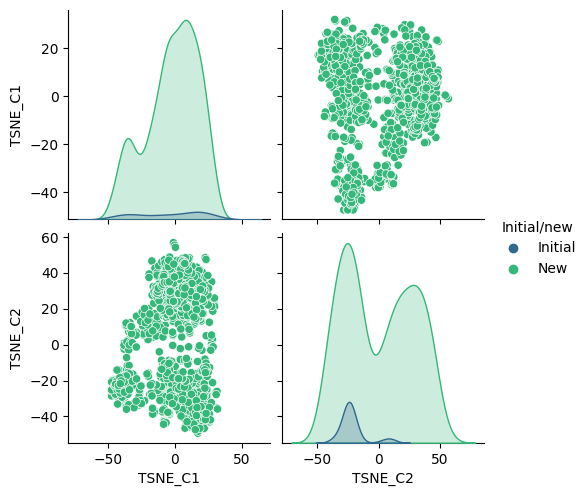

In [12]:
# t-SNE plot
sns.pairplot(whole_df, hue='Initial/new', vars=['TSNE_C1', 'TSNE_C2'], palette='viridis')

In [13]:
x_t = whole_df.loc[whole_df['Initial/new'] == 'Initial']
len(x_t)

44

In [14]:
x_r = whole_df.loc[whole_df['Initial/new'] == 'New']
len(x_r)

891

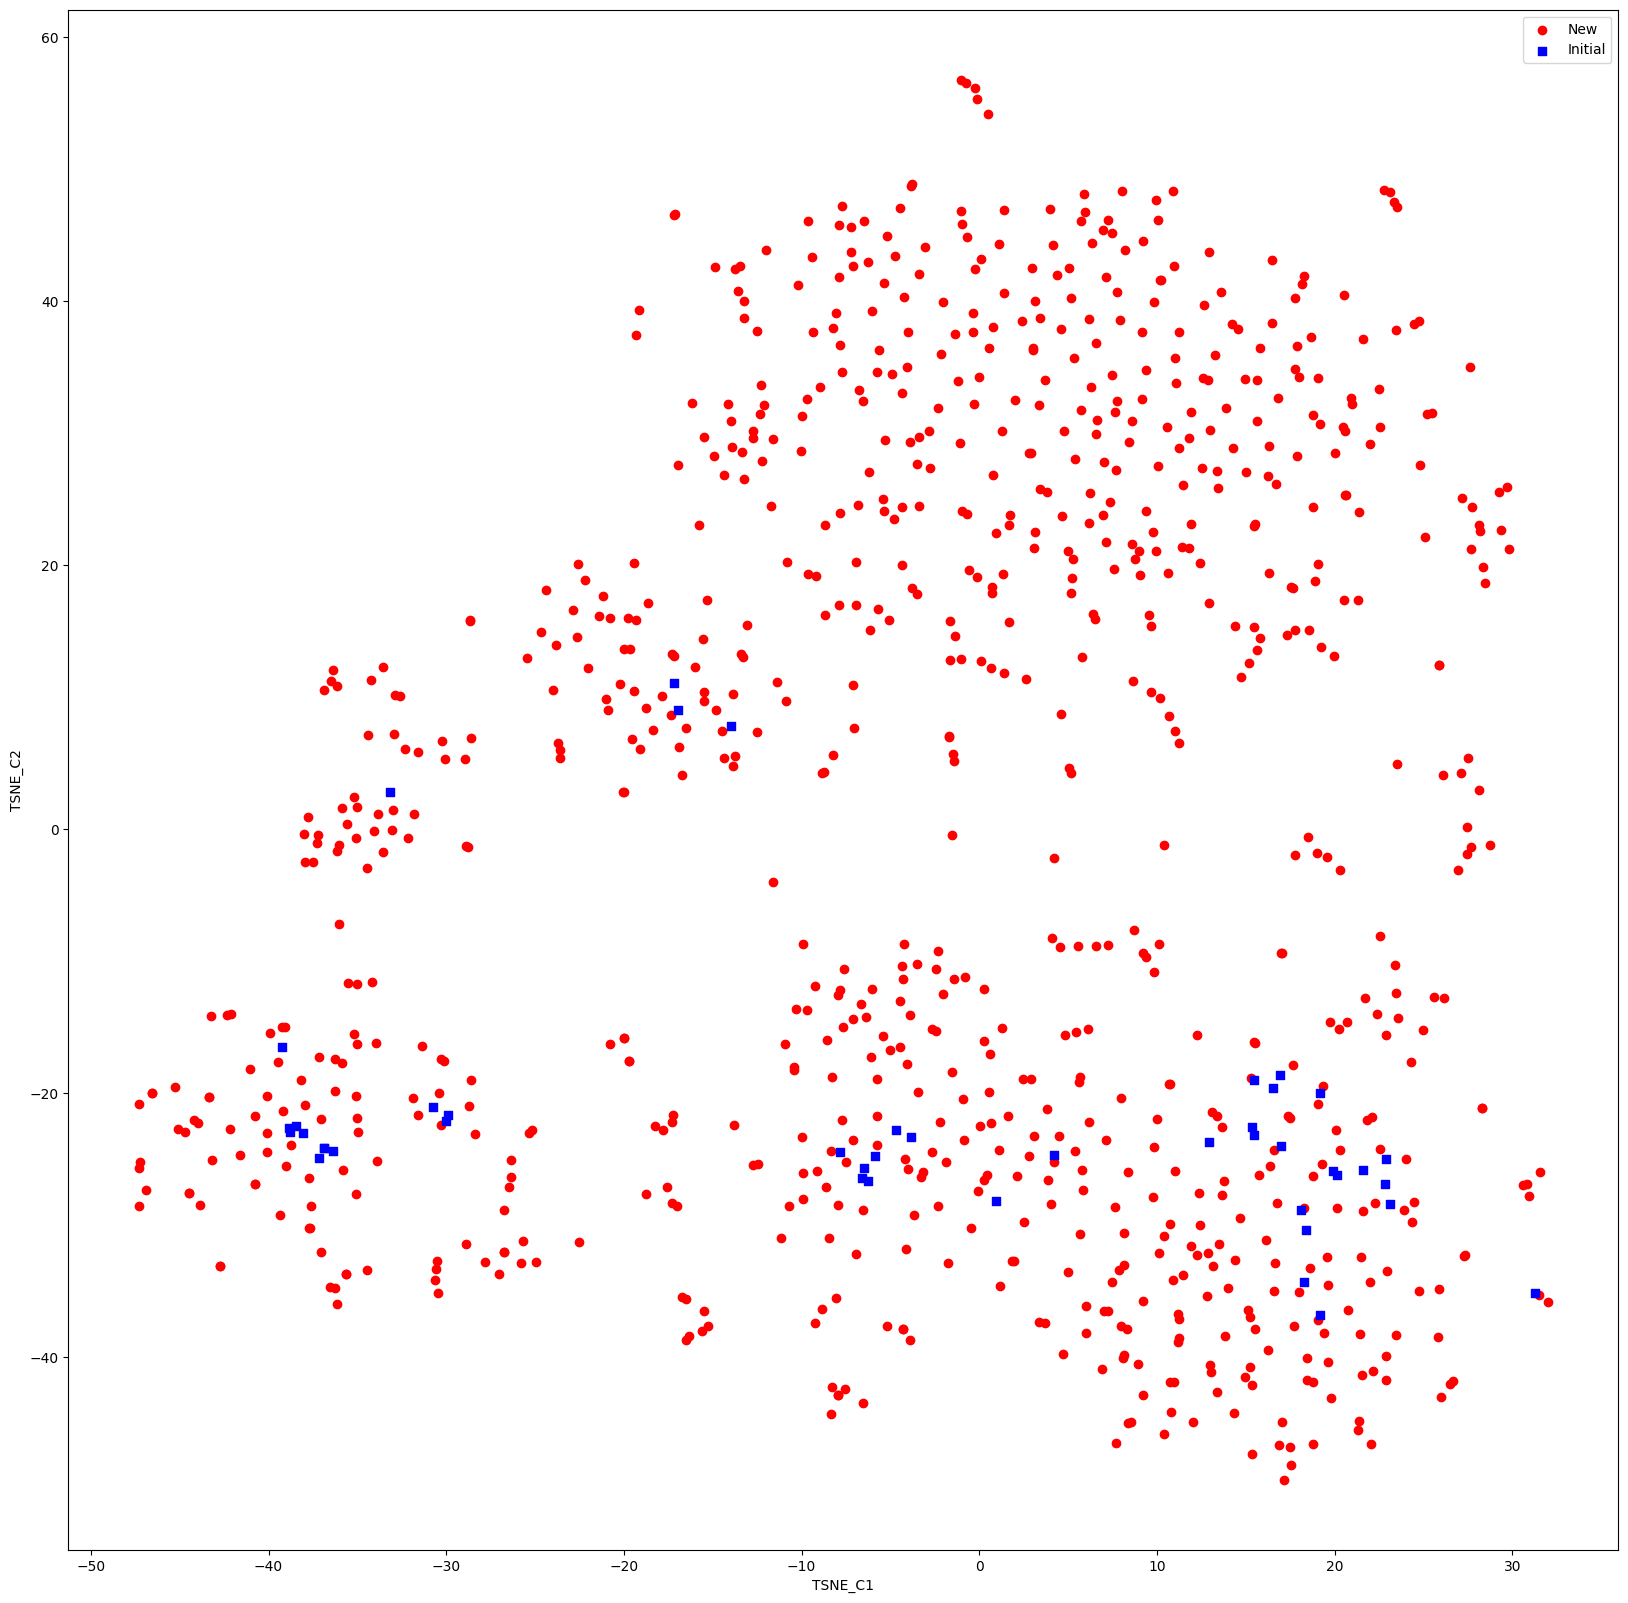

In [15]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)

ax.scatter(x_r['TSNE_C1'], x_r['TSNE_C2'], c='r', marker="o", label='New') #, alpha=1
ax.scatter(x_t['TSNE_C1'], x_t['TSNE_C2'], c='b', marker="s", label='Initial')#, alpha=0.1
plt.legend(loc='upper right')
plt.xlabel('TSNE_C1')
plt.ylabel('TSNE_C2')
plt.show()
#plt.savefig("The_Chemical_space_t-SNE_ref.svg", dpi=600)

In [16]:
# PCA analysis
pca = PCA(n_components=5, random_state=42) #n_components=20 in the case of activity_pred_app
pca_training_whole = pca.fit_transform(data_)

In [17]:
list_pca = []
for i in range(5):
    list_pca.append('PC'+str(i+1))

In [18]:
for pca_ in range(5):
    whole_df[list_pca[pca_]] = pca_training_whole.T[pca_]

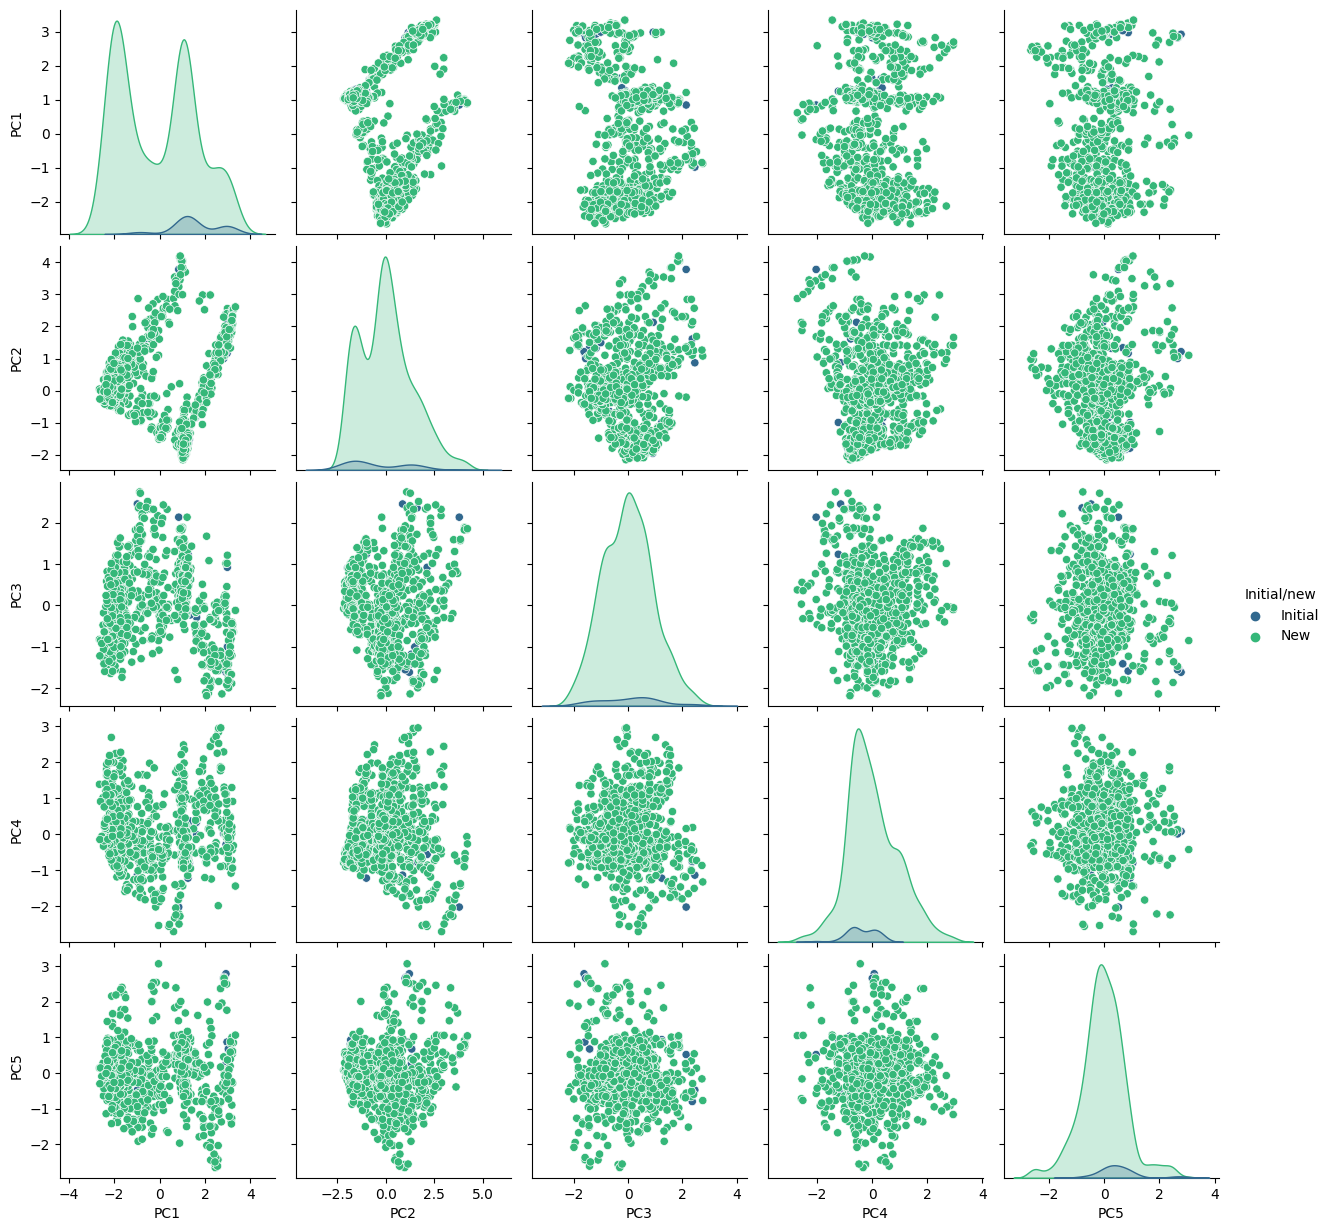

In [19]:
sns.pairplot(whole_df, hue='Initial/new', vars=list_pca, palette='viridis')

In [20]:
# t-SNE analysis
model = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=5000)
tsne_whole_set = model.fit_transform(pca_training_whole)

In [21]:
whole_df['TSNE_C1'] = tsne_whole_set.T[0]
whole_df['TSNE_C2'] = tsne_whole_set.T[1]

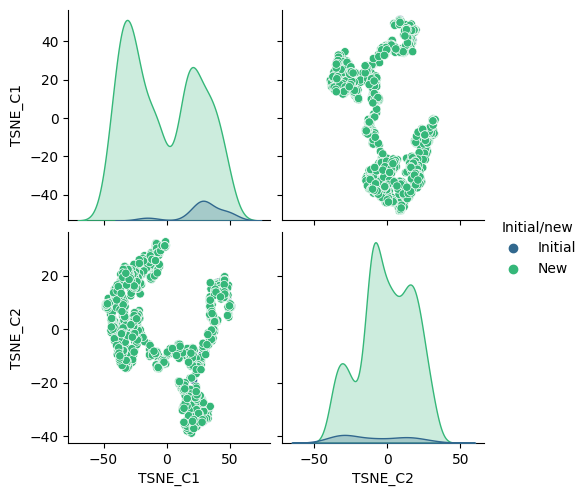

In [22]:
# t-SNE plot
sns.pairplot(whole_df, hue='Initial/new', vars=['TSNE_C1', 'TSNE_C2'], palette='viridis')

In [23]:
x_t = whole_df.loc[whole_df['Initial/new'] == 'Initial']
print(len(x_t))
x_r = whole_df.loc[whole_df['Initial/new'] == 'New']
len(x_r)

44


891

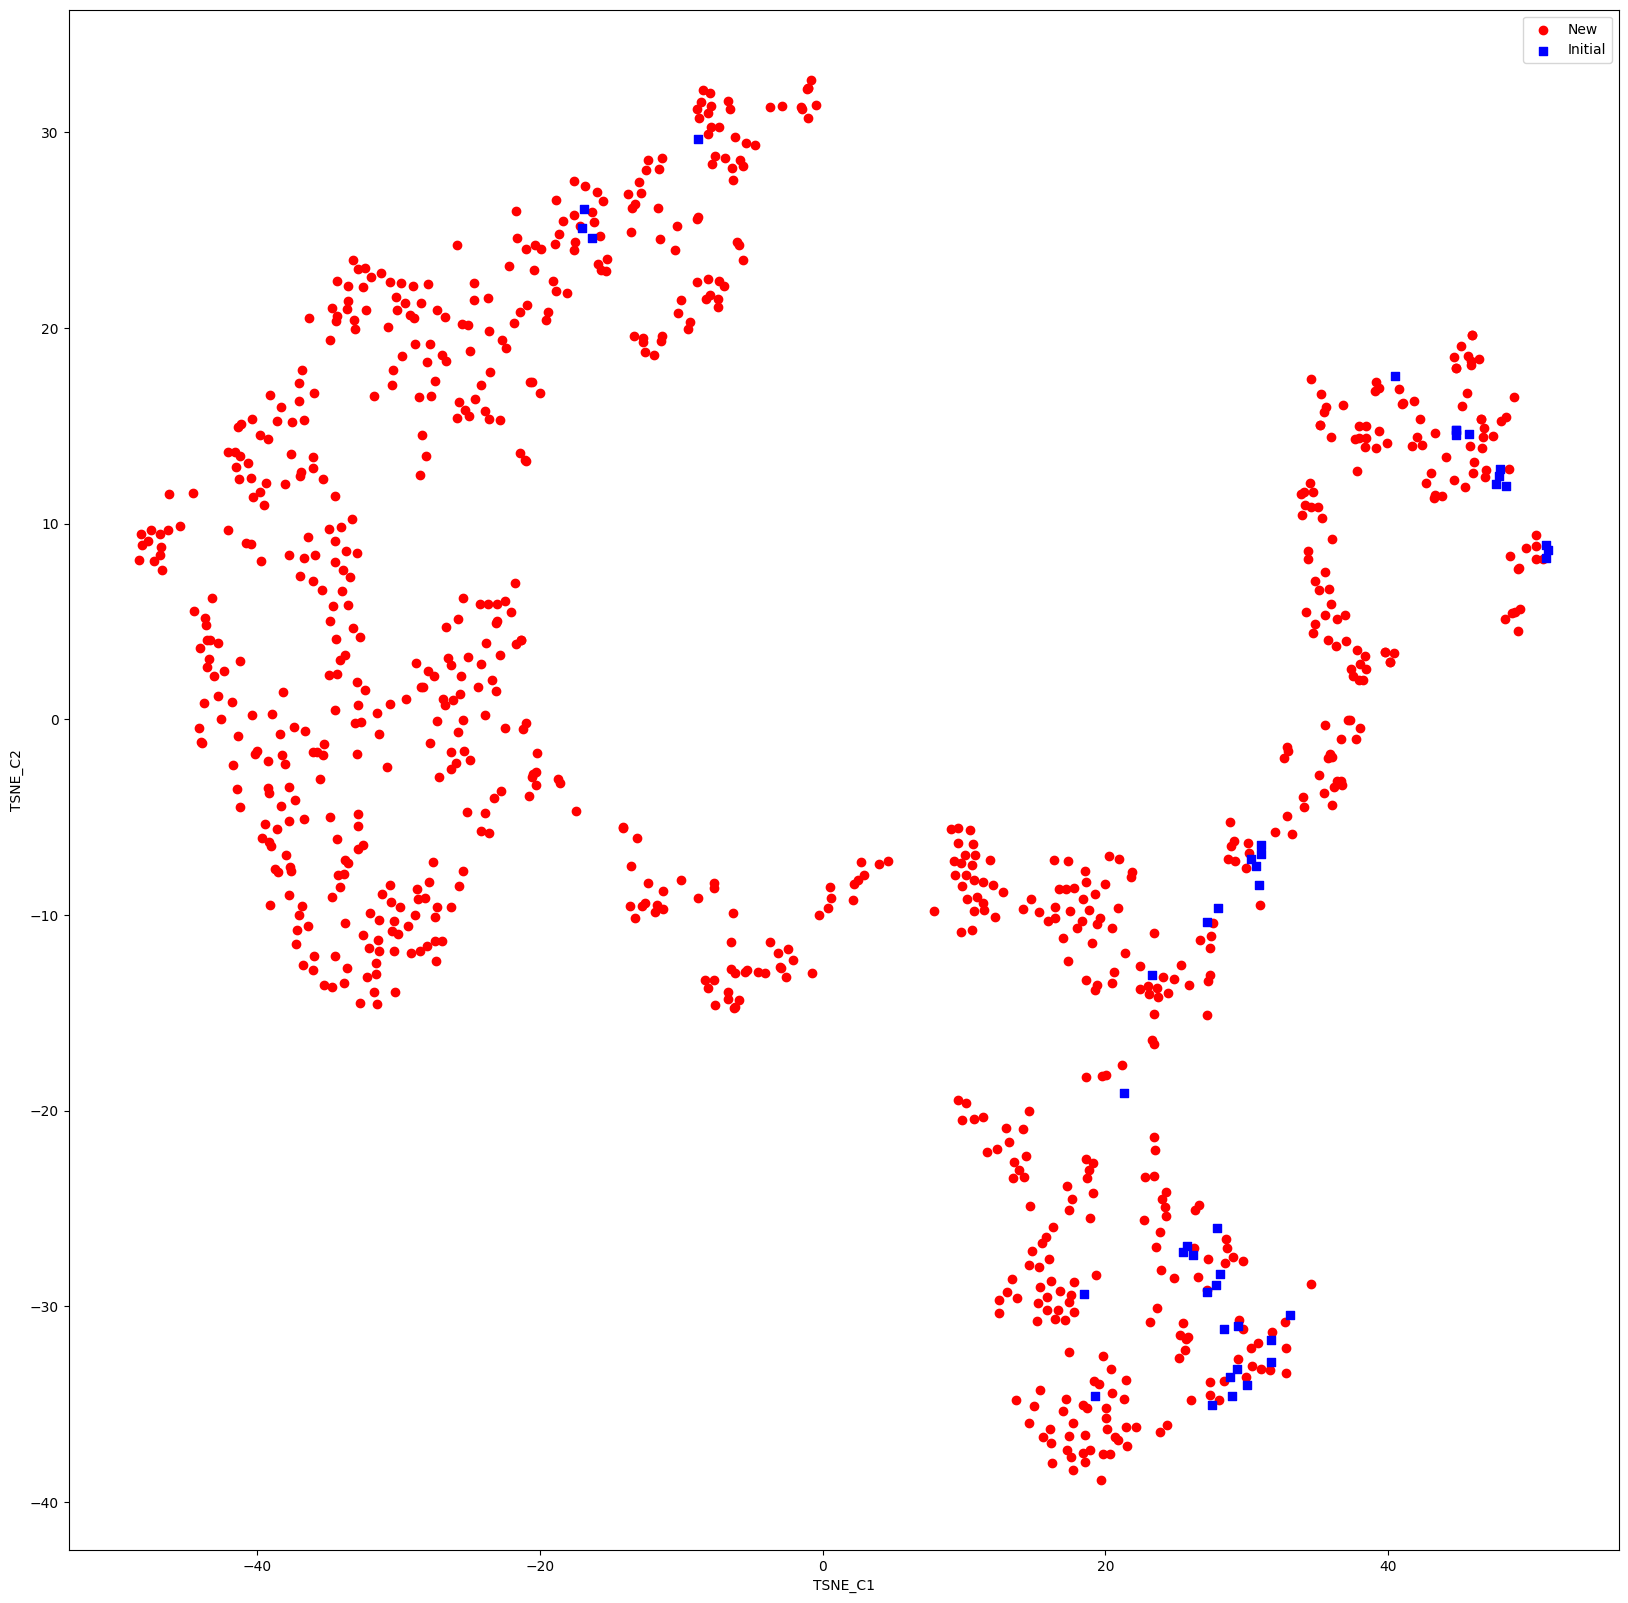

In [24]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)

ax.scatter(x_r['TSNE_C1'], x_r['TSNE_C2'], c='r', marker="o", label='New') #, alpha=1
ax.scatter(x_t['TSNE_C1'], x_t['TSNE_C2'], c='b', marker="s", label='Initial')#, alpha=0.1
plt.legend(loc='upper right')
plt.xlabel('TSNE_C1')
plt.ylabel('TSNE_C2')
plt.show()
#plt.savefig("The_Chemical_space_t-SNE_ref.svg", dpi=600)